In [12]:
!pip install simpletransformers

In [13]:
# import torch

import re
import os
import math
import random
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import learning_curve
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

from scipy.special import softmax
from scipy.sparse import hstack ,vstack



from simpletransformers.classification import ClassificationModel, ClassificationArgs
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

In [14]:
olid_url = 'https://raw.githubusercontent.com/Mohammed-majeed/Subjectivity-Mining/main/Assignment%205%20-%20Group%2011/Datasets/olid-train-small.csv'
olid_test_url = "https://raw.githubusercontent.com/Mohammed-majeed/Subjectivity-Mining/main/Assignment%205%20-%20Group%2011/Datasets/olid-test.csv"

hasoc_url = "https://raw.githubusercontent.com/Mohammed-majeed/Subjectivity-Mining/main/Assignment%205%20-%20Group%2011/Datasets/hasoc-train.csv"

hate_lexicon = "https://raw.githubusercontent.com/Mohammed-majeed/Subjectivity-Mining/main/Assignment%205%20-%20Group%2011/Datasets/expandedLexicon.txt"

In [15]:

# To make the output reproducible set seed to 42
# Set random seed for Python's random module
random_seed = 42
random.seed(random_seed)

# Set random seed for NumPy
np.random.seed(random_seed)

In [16]:
OLIDv1_train_df = (pd.read_csv(olid_url)).drop("id",axis = 1)  # length 5852
OLIDv1_test_df = (pd.read_csv(olid_test_url)).drop("id",axis = 1)         # length 860

hasoc_train_df = (pd.read_csv(hasoc_url)).drop("id",axis = 1)       # length 5852

lexicon_df = pd.read_csv(hate_lexicon, sep='\t', header=None, names=["word", "label"], encoding="utf-8")
lexicon_df['word'] = lexicon_df['word'].str.replace(r'_[a-zA-Z]+$', '', regex=True)


In [17]:
# Split the OLIDv1_train_df into input features and labels
X_olid = OLIDv1_train_df['text']
Y_olid = OLIDv1_train_df['labels']

# Split the hasoc_train_df into input features and labels
X_hasoc = hasoc_train_df['text']
Y_hasoc = hasoc_train_df['labels']

# Split the OLIDv1_train_df dataset into a training set and a validation set
X_train_olid, X_val_olid, Y_train_olid, Y_val_olid = train_test_split(X_olid, Y_olid, test_size=0.2, random_state=42)


train_olid = pd.concat([X_train_olid, Y_train_olid], axis=1)
val_olid = pd.concat([X_val_olid, Y_val_olid], axis=1)

# Split the hasoc_train_df dataset into a training set and a validation set
X_train_hasoc, X_val_hasoc, Y_train_hasoc, Y_val_hasoc = train_test_split(X_hasoc, Y_hasoc, test_size=0.2, random_state=42)

train_hasoc = pd.concat([X_train_hasoc, Y_train_hasoc], axis=1)
val_hasoc = pd.concat([X_val_hasoc, Y_val_hasoc], axis=1)

In [18]:
# print and plot confusion matrix
def print_and_plot_confusion_matrix(true_labels, predicted_labels, experiment_name):
    cm = confusion_matrix(true_labels, predicted_labels)
    print(f'Confusion Matrix for {experiment_name}:')
    print(cm)

    # Plotting the confusion matrix
    plt.figure(figsize=(8, 6))
    # Adjust the font size for better visualization
    sns.set(font_scale=1.2)
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
                xticklabels=['No hate', 'Hate'],
                yticklabels=['No hate', 'Hate'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix for {experiment_name}')
    plt.show()

In [19]:
# calculate and print classification report
def print_classification_report(true_labels, predicted_labels, experiment_name):
    report = classification_report(true_labels, predicted_labels)
    print(f'Classification Report for {experiment_name}:')
    print(report)

In [20]:
# def plot_losses(training_log,formatted_experiment_name):
#     plt.plot(training_log['train_loss'], label='training Loss')
#     plt.plot(training_log['eval_loss'], label='validation Loss')
#     plt.title('Training and validation loss over epochs \n'+formatted_experiment_name)
#     plt.xlabel('Evaluation Steps')
#     plt.ylabel('Loss')
#     plt.legend()
#     plt.show()

# Transformer based models


In [21]:
def fine_tune_and_evaluate(experiment_name, train_dataset, val_dataset, test_dataset,
                           model_type, model_case, retrain=False, num_folds=1):
    best_model_directory = None
    model_directory = None
    if num_folds <= 1:
        # If num_folds is 1 or less, train and evaluate on the full training dataset without cross-validation
        model_directory = f"output/{model_type}/{model_case}/{experiment_name}"
        best_model_directory = model_directory + '/best_model'
    else:
        # Prepare k-fold cross-validation
        kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
        model_directory = f"output/{model_type}/{model_case}/cv{num_folds}/{experiment_name}"
        best_model_directory = model_directory + '/best_model'


    # Initialize df to store validation data, predictions,
    val_df = pd.DataFrame()

    model_arguments = ClassificationArgs(output_dir=model_directory,
                                      best_model_dir=best_model_directory,
                                      save_best_model=True,
                                      reprocess_input_data = True,
                                      overwrite_output_dir=True,
                                      no_cache=True,

                                      evaluate_during_training = True,
                                      evaluate_during_training_verbose = True,
                                    #  evaluate_during_training_steps = 120,
                                    #  use_cached_eval_features = True,
                                    #  save_eval_checkpoints = True,
                                      save_model_every_epoch = False,

                                      use_early_stopping = True,
                                      early_stopping_metric = "eval_loss",
                                      early_stopping_metric_minimize = True,
                                      early_stopping_patience = 2,
                                      early_stopping_delta = 0.01,

                                    #  learning_rate= 1e-6,
                                    #  num_train_epochs=5,
                                    #  train_batch_size=32,
                                    #  eval_batch_size=32,
                                      max_seq_length = 128
                                      )

    # Loop through the folds if using cross-validation
    if num_folds > 1:
        # Train or load the model based on the existence of the model directory
        if not os.path.exists(model_directory) or retrain:
            model = ClassificationModel(model_type, model_case, args=model_arguments, use_cuda=True)
            for train_index, val_index in kf.split(train_dataset.text, train_dataset.labels):
                train_fold, val_fold = train_dataset.iloc[train_index], train_dataset.iloc[val_index]
                model.train_model(train_fold, eval_df=val_fold)

                # Make predictions on the validation dataset for this fold
                val_predictions, _ = model.predict(list(val_fold.text))

                val_fold[f"prediction{model_type}"] = val_predictions

                # Append predictions from val_fold to val_df
                val_df = pd.concat([val_df, val_fold], axis=0)

        else:
            model = ClassificationModel(model_type, model_directory, args=model_arguments, use_cuda=True)


    else:
        # Train the model on the full training dataset without cross-validation
        # Train or load the model based on the existence of the model directory
        if not os.path.exists(model_directory) or retrain:
            model = ClassificationModel(model_type, model_case, args=model_arguments, use_cuda=True)
            model.train_model(train_dataset, eval_df=val_dataset)
        else:
            model = ClassificationModel(model_type, model_directory, args=model_arguments, use_cuda=True)




    # Make predictions on the test dataset
    test_predictions, test_probabilities = model.predict(list(test_dataset.text))

    # Calculate softmax probabilities for Soft Majority Voting
    softmax_probabilities = softmax(test_probabilities, axis=1)

    # Format the experiment name for display
    formatted_experiment_name = f'{model_type}" / "{model_case}" / "{experiment_name}'

    # Print and plot confusion matrix
    print_and_plot_confusion_matrix(test_dataset.labels, test_predictions, formatted_experiment_name)

    # Print classification report
    print_classification_report(test_dataset.labels, test_predictions, formatted_experiment_name)

    # Return predictions, probabilities for ensembling, aggregated validation data, predictions, and indices as pandas DataFrames
    return test_predictions, softmax_probabilities, val_df


======================
# xlnet
======================

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'logits_proj.bias', 'sequence_summary.summary.weight', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/4681 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/586 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


  0%|          | 0/1171 [00:00<?, ?it/s]

  0%|          | 0/860 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Confusion Matrix for xlnet" / "xlnet-base-cased" / "in-domain-experiment:
[[548  72]
 [ 83 157]]


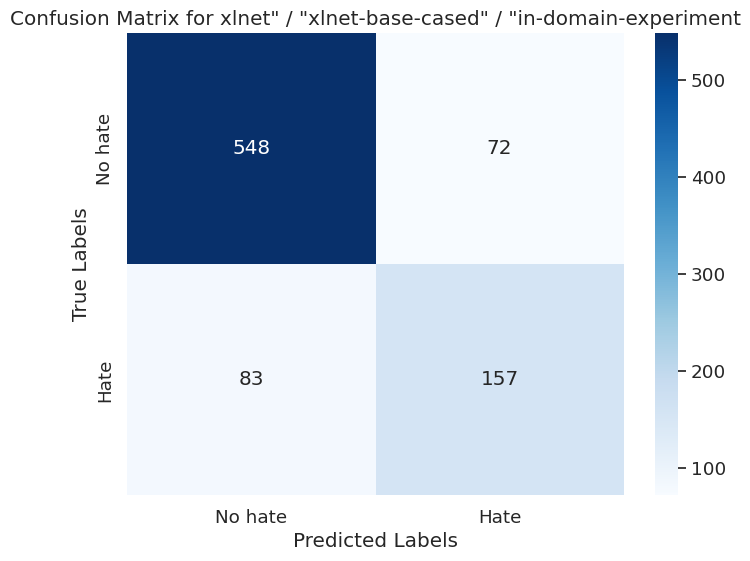

Classification Report for xlnet" / "xlnet-base-cased" / "in-domain-experiment:
              precision    recall  f1-score   support

           0       0.87      0.88      0.88       620
           1       0.69      0.65      0.67       240

    accuracy                           0.82       860
   macro avg       0.78      0.77      0.77       860
weighted avg       0.82      0.82      0.82       860



In [22]:
# Train and evaluate the model xlnet in-domain

xlnet_predictions, xlnet_probabilities,_ = fine_tune_and_evaluate(experiment_name='in-domain-experiment',
                       train_dataset = train_olid, val_dataset = val_olid,
                       test_dataset = OLIDv1_test_df,
                       model_type='xlnet', model_case='xlnet-base-cased', retrain=True)


Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'logits_proj.bias', 'sequence_summary.summary.weight', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/4681 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/586 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


  0%|          | 0/1171 [00:00<?, ?it/s]

  0%|          | 0/860 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Confusion Matrix for xlnet" / "xlnet-base-cased" / "Cross-domain-experiment:
[[552  68]
 [ 97 143]]


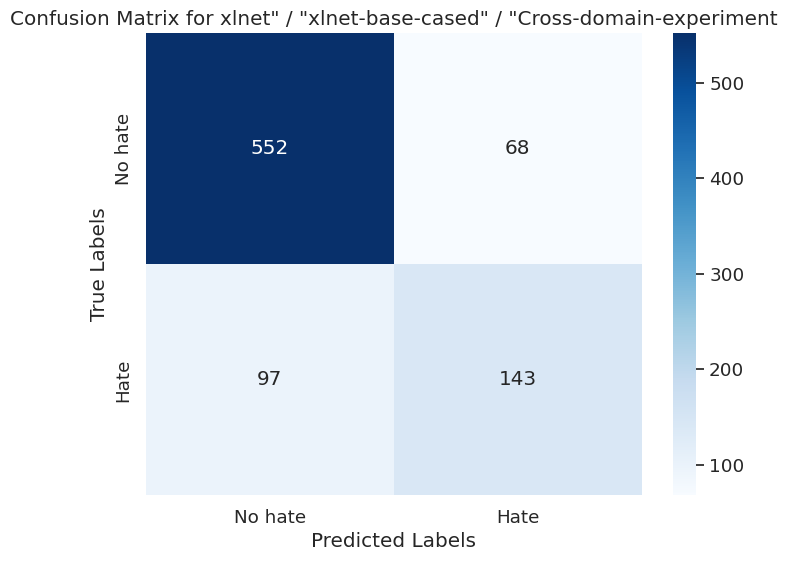

Classification Report for xlnet" / "xlnet-base-cased" / "Cross-domain-experiment:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87       620
           1       0.68      0.60      0.63       240

    accuracy                           0.81       860
   macro avg       0.76      0.74      0.75       860
weighted avg       0.80      0.81      0.80       860



In [23]:
# Train and evaluate the model xlnet Cross-domain
cross_xlnet_predictions, cross_xlnet_probabilities,_ = fine_tune_and_evaluate(experiment_name='Cross-domain-experiment',
                        train_dataset=train_hasoc, val_dataset=val_hasoc,
                       test_dataset = OLIDv1_test_df,
                       model_type='xlnet', model_case='xlnet-base-cased', retrain=True)


======================
# hateBert
======================

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/4681 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/586 [00:00<?, ?it/s]

  0%|          | 0/1171 [00:00<?, ?it/s]

  0%|          | 0/860 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Confusion Matrix for bert" / "GroNLP/hateBERT" / "in-domain-experiment:
[[565  55]
 [ 85 155]]


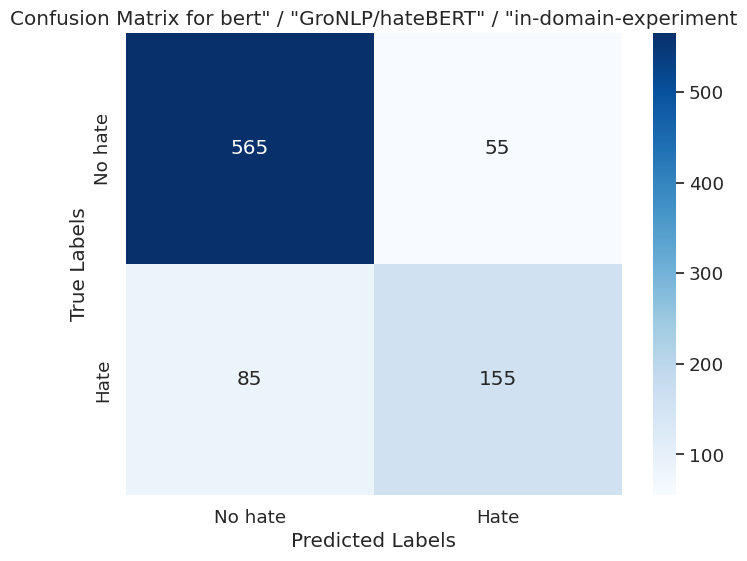

Classification Report for bert" / "GroNLP/hateBERT" / "in-domain-experiment:
              precision    recall  f1-score   support

           0       0.87      0.91      0.89       620
           1       0.74      0.65      0.69       240

    accuracy                           0.84       860
   macro avg       0.80      0.78      0.79       860
weighted avg       0.83      0.84      0.83       860



In [24]:
# Train and evaluate the model hateBert in-domain
hateBERT_predictions, hateBERT_probabilities,_ = fine_tune_and_evaluate(experiment_name='in-domain-experiment',
                       train_dataset = train_olid, val_dataset = val_olid,
                       test_dataset = OLIDv1_test_df,
                       model_type = 'bert', model_case='GroNLP/hateBERT',retrain=True)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/4681 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/586 [00:00<?, ?it/s]

  0%|          | 0/1171 [00:00<?, ?it/s]

  0%|          | 0/860 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Confusion Matrix for bert" / "GroNLP/hateBERT" / "Cross-domain-experiment:
[[582  38]
 [150  90]]


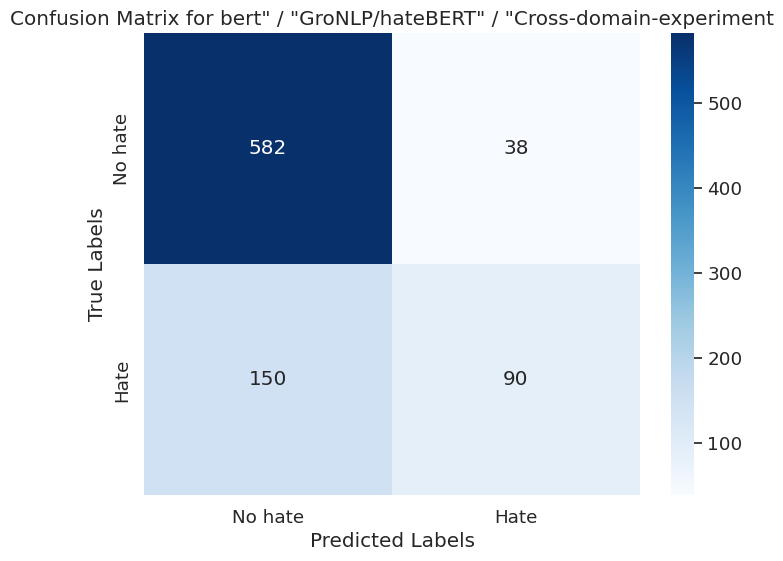

Classification Report for bert" / "GroNLP/hateBERT" / "Cross-domain-experiment:
              precision    recall  f1-score   support

           0       0.80      0.94      0.86       620
           1       0.70      0.38      0.49       240

    accuracy                           0.78       860
   macro avg       0.75      0.66      0.68       860
weighted avg       0.77      0.78      0.76       860



In [25]:
# Train and evaluate the model hateBert Cross-domain
cross_hateBERT_predictions, cross_hateBERT_probabilities,_ = fine_tune_and_evaluate(experiment_name='Cross-domain-experiment',
                        train_dataset=train_hasoc, val_dataset=val_hasoc,
                       test_dataset=OLIDv1_test_df,
                       model_type = 'bert', model_case='GroNLP/hateBERT',retrain=True)


======================
# Roberta model
======================

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/4681 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/586 [00:00<?, ?it/s]

  0%|          | 0/1171 [00:00<?, ?it/s]

  0%|          | 0/860 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Confusion Matrix for roberta" / "roberta-base" / "in-domain-experiment:
[[564  56]
 [ 79 161]]


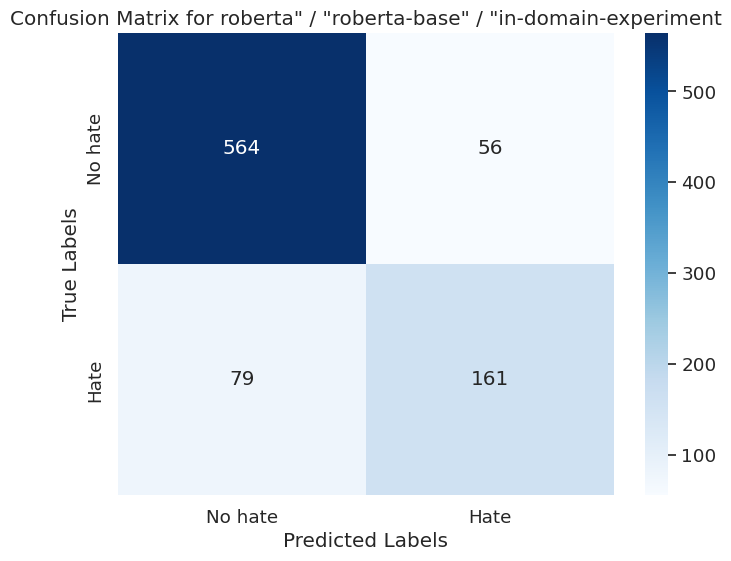

Classification Report for roberta" / "roberta-base" / "in-domain-experiment:
              precision    recall  f1-score   support

           0       0.88      0.91      0.89       620
           1       0.74      0.67      0.70       240

    accuracy                           0.84       860
   macro avg       0.81      0.79      0.80       860
weighted avg       0.84      0.84      0.84       860



In [26]:
# Train and evaluate the model roberta in-domain

roberta_predictions, roberta_probabilities,_ = fine_tune_and_evaluate(experiment_name='in-domain-experiment',
                       train_dataset = train_olid, val_dataset = val_olid,
                       test_dataset = OLIDv1_test_df,
                       model_type='roberta', model_case='roberta-base', retrain=True)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/4681 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/586 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


  0%|          | 0/1171 [00:00<?, ?it/s]

  0%|          | 0/860 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Confusion Matrix for roberta" / "roberta-base" / "Cross-domain-experiment:
[[561  59]
 [100 140]]


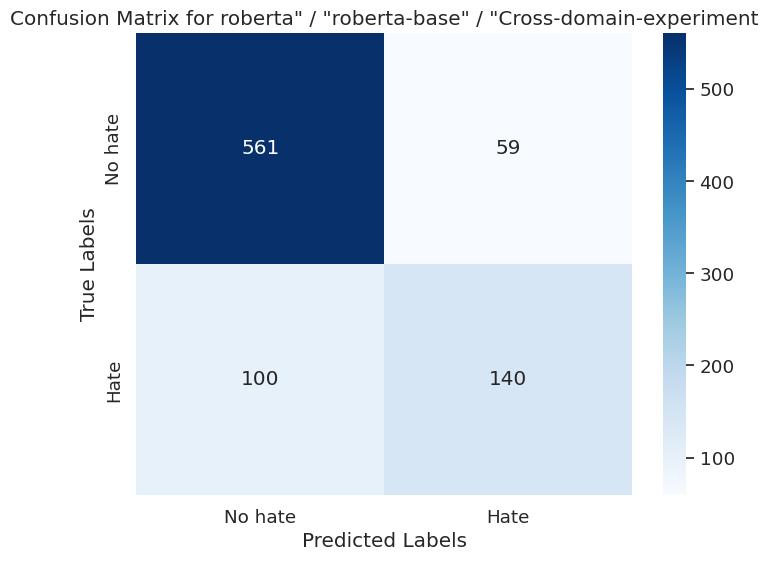

Classification Report for roberta" / "roberta-base" / "Cross-domain-experiment:
              precision    recall  f1-score   support

           0       0.85      0.90      0.88       620
           1       0.70      0.58      0.64       240

    accuracy                           0.82       860
   macro avg       0.78      0.74      0.76       860
weighted avg       0.81      0.82      0.81       860



In [27]:
# Train and evaluate the model roberta Cross-domain

cross_roberta_predictions, cross_roberta_probabilities,_ = fine_tune_and_evaluate(experiment_name='Cross-domain-experiment',
                       train_dataset=train_hasoc, val_dataset=val_hasoc,
                       test_dataset=OLIDv1_test_df,
                       model_type='roberta', model_case='roberta-base', retrain=True)


=================
# hard Majority Voting
=================

In [28]:
# Hard Majority Voting
def hard_majority_voting(predictions_list):
    # Stack the predictions vertically to get a matrix where each row represents predictions from a model
    stacked_predictions = np.vstack(predictions_list)
    # Calculate majority vote along each column
    majority_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x)), axis=0, arr=stacked_predictions)
    return majority_vote

Confusion Matrix for Hard Majority Voting in-domain:
[[572  48]
 [ 82 158]]


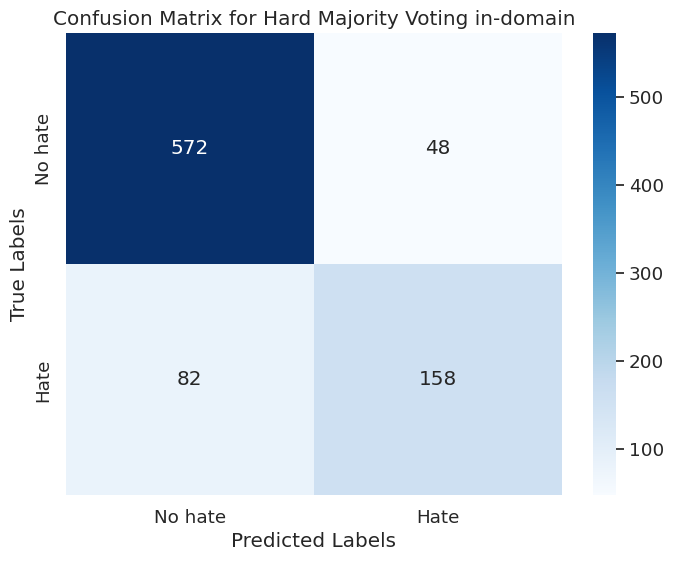

Classification Report for Hard Majority Voting in-domain:
              precision    recall  f1-score   support

           0       0.87      0.92      0.90       620
           1       0.77      0.66      0.71       240

    accuracy                           0.85       860
   macro avg       0.82      0.79      0.80       860
weighted avg       0.84      0.85      0.85       860



In [29]:
# Perform Hard Majority Voting in-domain

# Combine predictions from different models
hard_majority_predictions = hard_majority_voting([xlnet_predictions, hateBERT_predictions, roberta_predictions])

# Print and plot confusion matrix
print_and_plot_confusion_matrix(OLIDv1_test_df.labels, hard_majority_predictions, "Hard Majority Voting in-domain")

# Print classification report
print_classification_report(OLIDv1_test_df.labels, hard_majority_predictions, "Hard Majority Voting in-domain")


Confusion Matrix for Hard Majority Voting cross-domain:
[[574  46]
 [109 131]]


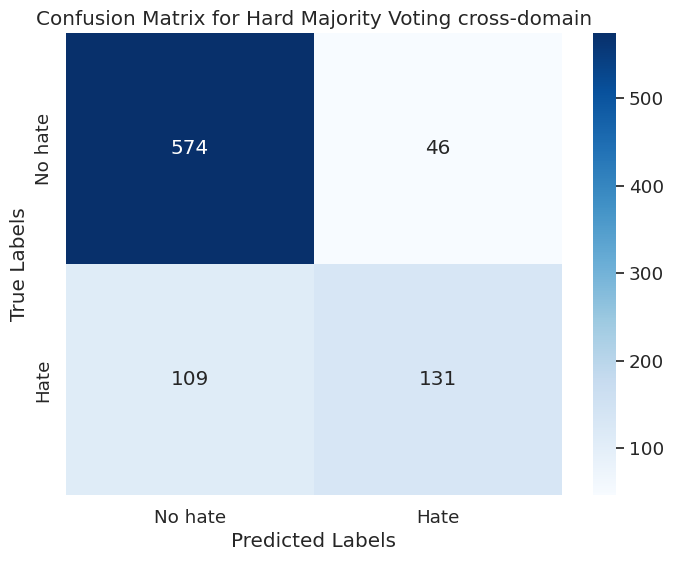

Classification Report for Hard Majority Voting cross-domain:
              precision    recall  f1-score   support

           0       0.84      0.93      0.88       620
           1       0.74      0.55      0.63       240

    accuracy                           0.82       860
   macro avg       0.79      0.74      0.75       860
weighted avg       0.81      0.82      0.81       860



In [30]:
# Perform Hard Majority Voting cross-domain

# Combine predictions from different models
cross_hard_majority_predictions = hard_majority_voting([cross_xlnet_predictions, cross_hateBERT_predictions, cross_roberta_predictions])

# Print and plot confusion matrix
print_and_plot_confusion_matrix(OLIDv1_test_df.labels, cross_hard_majority_predictions, "Hard Majority Voting cross-domain")

# Print classification report
print_classification_report(OLIDv1_test_df.labels, cross_hard_majority_predictions, "Hard Majority Voting cross-domain")


=================
# Soft Majority Voting
=================

In [31]:
# Soft Majority Voting
def soft_majority_voting(probabilities_list):
    # Add all arrays element-wise
    sum_arrays = np.sum(probabilities_list, axis=0)
    # Calculate the average
    average_array = sum_arrays / 3
    # Get the index of the maximum value in the average array
    final_prediction = np.argmax(average_array, axis=1)
    return final_prediction

Confusion Matrix for Soft Majority Voting in-domain:
[[573  47]
 [ 74 166]]


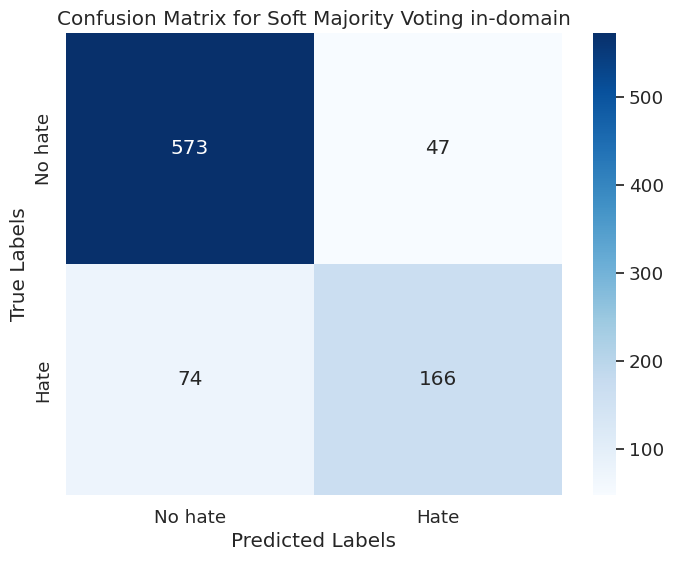

Classification Report for Soft Majority Voting in-domain:
              precision    recall  f1-score   support

           0       0.89      0.92      0.90       620
           1       0.78      0.69      0.73       240

    accuracy                           0.86       860
   macro avg       0.83      0.81      0.82       860
weighted avg       0.86      0.86      0.86       860



In [32]:
# Perform Soft Majority Voting in-domain

soft_majority_prediction = soft_majority_voting([xlnet_probabilities, hateBERT_probabilities, roberta_probabilities])

# Print and plot confusion matrix
print_and_plot_confusion_matrix(OLIDv1_test_df.labels, soft_majority_prediction, "Soft Majority Voting in-domain")

# Print classification report
print_classification_report(OLIDv1_test_df.labels, soft_majority_prediction, "Soft Majority Voting in-domain")


Confusion Matrix for Soft Majority Voting cross domain:
[[568  52]
 [106 134]]


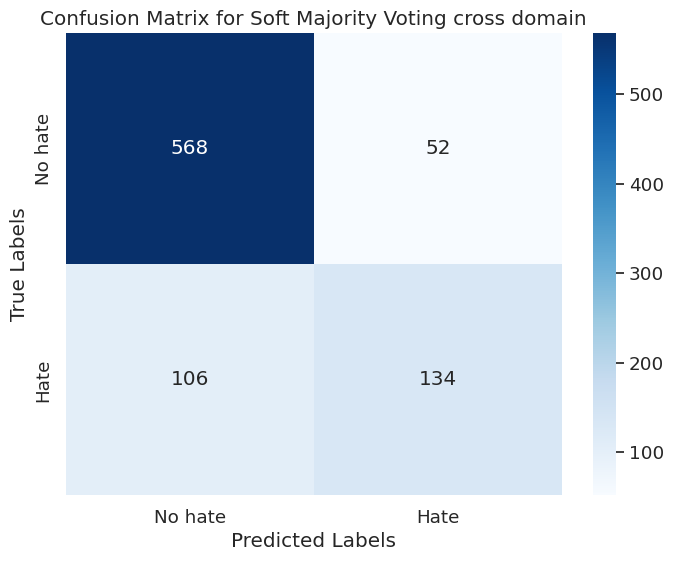

Classification Report for Soft Majority Voting cross domain:
              precision    recall  f1-score   support

           0       0.84      0.92      0.88       620
           1       0.72      0.56      0.63       240

    accuracy                           0.82       860
   macro avg       0.78      0.74      0.75       860
weighted avg       0.81      0.82      0.81       860



In [33]:
# Perform Soft Majority Voting cross-domain

cross_soft_majority_prediction = soft_majority_voting([cross_xlnet_probabilities, cross_hateBERT_probabilities, cross_roberta_probabilities])

# Print and plot confusion matrix
print_and_plot_confusion_matrix(OLIDv1_test_df.labels, cross_soft_majority_prediction, "Soft Majority Voting cross domain")

# Print classification report
print_classification_report(OLIDv1_test_df.labels, cross_soft_majority_prediction, "Soft Majority Voting cross domain")

=================
# Stacking ensemble
=================

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'logits_proj.bias', 'sequence_summary.summary.weight', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/4681 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/586 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


  0%|          | 0/1171 [00:00<?, ?it/s]

  0%|          | 0/1171 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

<ipython-input-21-c82e727dfe4c>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_fold[f"prediction{model_type}"] = val_predictions


  0%|          | 0/4681 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/586 [00:00<?, ?it/s]

  0%|          | 0/1171 [00:00<?, ?it/s]

  0%|          | 0/1171 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

<ipython-input-21-c82e727dfe4c>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_fold[f"prediction{model_type}"] = val_predictions


  0%|          | 0/4682 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/586 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

<ipython-input-21-c82e727dfe4c>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_fold[f"prediction{model_type}"] = val_predictions


  0%|          | 0/4682 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/586 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

<ipython-input-21-c82e727dfe4c>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_fold[f"prediction{model_type}"] = val_predictions


  0%|          | 0/4682 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/586 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

<ipython-input-21-c82e727dfe4c>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_fold[f"prediction{model_type}"] = val_predictions


  0%|          | 0/860 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Confusion Matrix for xlnet" / "xlnet-base-cased" / "in-domain-experiment:
[[527  93]
 [ 71 169]]


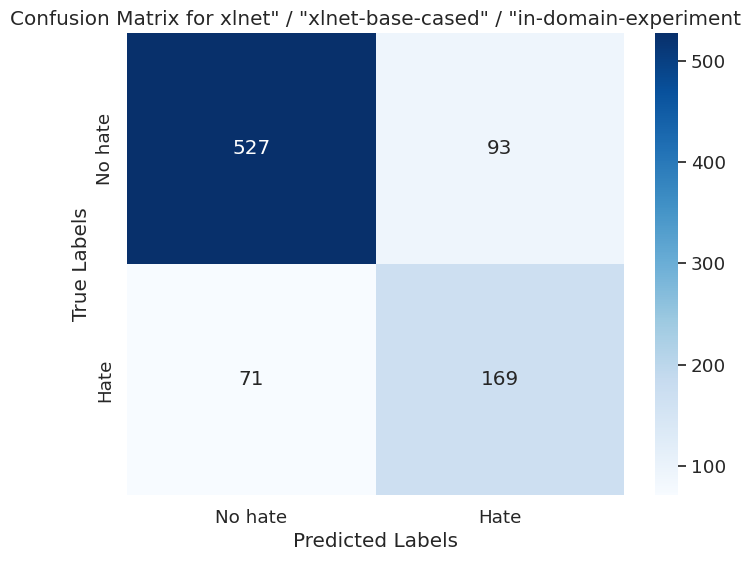

Classification Report for xlnet" / "xlnet-base-cased" / "in-domain-experiment:
              precision    recall  f1-score   support

           0       0.88      0.85      0.87       620
           1       0.65      0.70      0.67       240

    accuracy                           0.81       860
   macro avg       0.76      0.78      0.77       860
weighted avg       0.82      0.81      0.81       860



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/4681 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/586 [00:00<?, ?it/s]

  0%|          | 0/1171 [00:00<?, ?it/s]

  0%|          | 0/1171 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

<ipython-input-21-c82e727dfe4c>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_fold[f"prediction{model_type}"] = val_predictions


  0%|          | 0/4681 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/586 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


  0%|          | 0/1171 [00:00<?, ?it/s]

  0%|          | 0/1171 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

<ipython-input-21-c82e727dfe4c>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_fold[f"prediction{model_type}"] = val_predictions


  0%|          | 0/4682 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/586 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

<ipython-input-21-c82e727dfe4c>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_fold[f"prediction{model_type}"] = val_predictions


  0%|          | 0/4682 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/586 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

<ipython-input-21-c82e727dfe4c>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_fold[f"prediction{model_type}"] = val_predictions


  0%|          | 0/4682 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/586 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

<ipython-input-21-c82e727dfe4c>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_fold[f"prediction{model_type}"] = val_predictions


  0%|          | 0/860 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Confusion Matrix for bert" / "GroNLP/hateBERT" / "in-domain-experiment:
[[517 103]
 [ 72 168]]


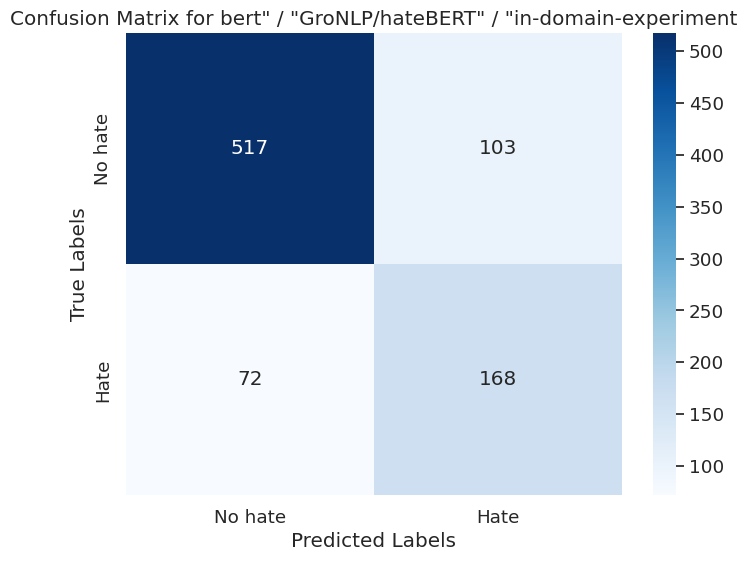

Classification Report for bert" / "GroNLP/hateBERT" / "in-domain-experiment:
              precision    recall  f1-score   support

           0       0.88      0.83      0.86       620
           1       0.62      0.70      0.66       240

    accuracy                           0.80       860
   macro avg       0.75      0.77      0.76       860
weighted avg       0.81      0.80      0.80       860



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/4681 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/586 [00:00<?, ?it/s]

  0%|          | 0/1171 [00:00<?, ?it/s]

  0%|          | 0/1171 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

<ipython-input-21-c82e727dfe4c>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_fold[f"prediction{model_type}"] = val_predictions


  0%|          | 0/4681 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/586 [00:00<?, ?it/s]

  0%|          | 0/1171 [00:00<?, ?it/s]

  0%|          | 0/1171 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

<ipython-input-21-c82e727dfe4c>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_fold[f"prediction{model_type}"] = val_predictions


  0%|          | 0/4682 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/586 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

<ipython-input-21-c82e727dfe4c>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_fold[f"prediction{model_type}"] = val_predictions


  0%|          | 0/4682 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/586 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

<ipython-input-21-c82e727dfe4c>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_fold[f"prediction{model_type}"] = val_predictions


  0%|          | 0/4682 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/586 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

<ipython-input-21-c82e727dfe4c>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_fold[f"prediction{model_type}"] = val_predictions


  0%|          | 0/860 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Confusion Matrix for roberta" / "roberta-base" / "in-domain-experiment:
[[545  75]
 [ 74 166]]


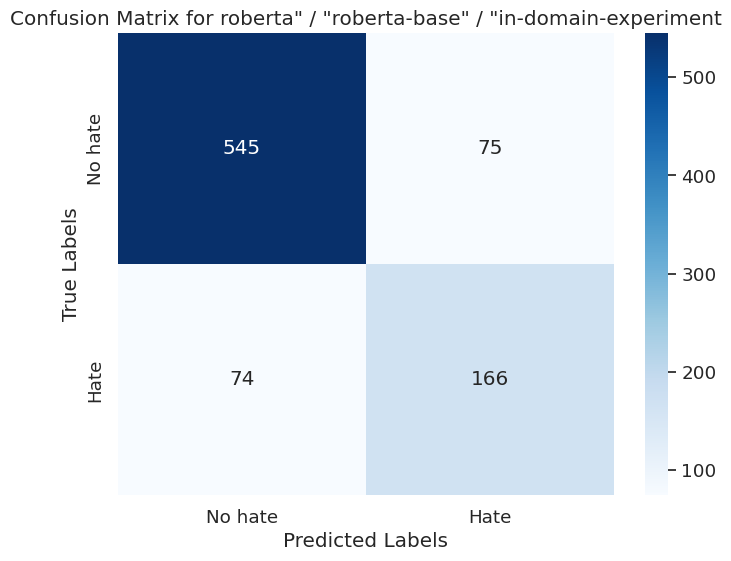

Classification Report for roberta" / "roberta-base" / "in-domain-experiment:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       620
           1       0.69      0.69      0.69       240

    accuracy                           0.83       860
   macro avg       0.78      0.79      0.78       860
weighted avg       0.83      0.83      0.83       860



In [51]:
# Stacking ensemble in-domain
Stacking_xlnet_predictions, Stacking_xlnet_probabilities, in_val_data_xlnet = fine_tune_and_evaluate(experiment_name='in-domain-experiment',
                       train_dataset = OLIDv1_train_df, val_dataset = val_olid,
                       test_dataset = OLIDv1_test_df,
                       model_type='xlnet', model_case='xlnet-base-cased', retrain=True, num_folds=5)

Stacking_hateBert_predictions, Stacking_hateBert_probabilities ,in_val_data_hateBert = fine_tune_and_evaluate(experiment_name='in-domain-experiment',
                       train_dataset = OLIDv1_train_df, val_dataset = val_olid,
                       test_dataset = OLIDv1_test_df,
                       model_type = 'bert', model_case='GroNLP/hateBERT',retrain=True, num_folds=5)

Stacking_Roberta_predictions, Stacking_Roberta_probabilities ,in_val_data_Roberta = fine_tune_and_evaluate(experiment_name='in-domain-experiment',
                       train_dataset = OLIDv1_train_df, val_dataset = val_olid,
                       test_dataset = OLIDv1_test_df,
                       model_type='roberta', model_case='roberta-base', retrain=True, num_folds=5)

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'logits_proj.bias', 'sequence_summary.summary.weight', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/4681 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/586 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


  0%|          | 0/1171 [00:00<?, ?it/s]

  0%|          | 0/1171 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

<ipython-input-21-c82e727dfe4c>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_fold[f"prediction{model_type}"] = val_predictions


  0%|          | 0/4681 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/586 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


  0%|          | 0/1171 [00:00<?, ?it/s]

  0%|          | 0/1171 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

<ipython-input-21-c82e727dfe4c>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_fold[f"prediction{model_type}"] = val_predictions


  0%|          | 0/4682 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/586 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

<ipython-input-21-c82e727dfe4c>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_fold[f"prediction{model_type}"] = val_predictions


  0%|          | 0/4682 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/586 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

<ipython-input-21-c82e727dfe4c>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_fold[f"prediction{model_type}"] = val_predictions


  0%|          | 0/4682 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/586 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

<ipython-input-21-c82e727dfe4c>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_fold[f"prediction{model_type}"] = val_predictions


  0%|          | 0/860 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Confusion Matrix for xlnet" / "xlnet-base-cased" / "Cross-domain-experiment:
[[553  67]
 [118 122]]


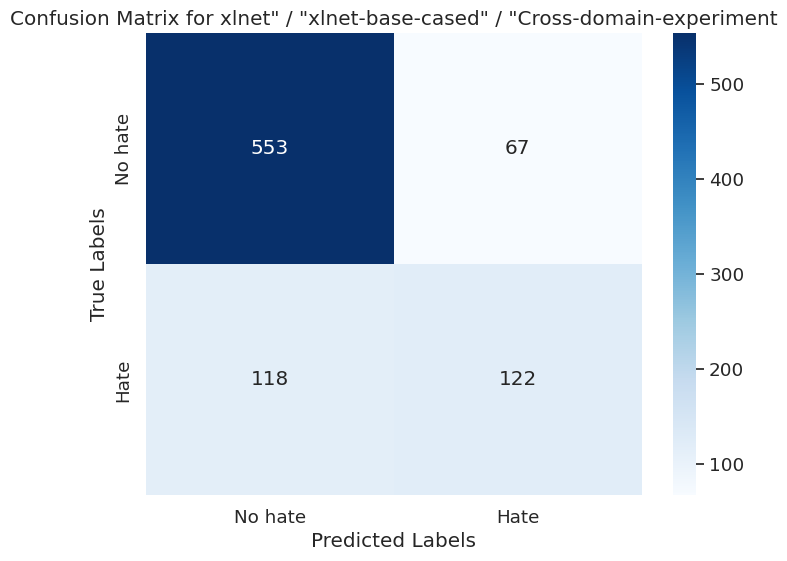

Classification Report for xlnet" / "xlnet-base-cased" / "Cross-domain-experiment:
              precision    recall  f1-score   support

           0       0.82      0.89      0.86       620
           1       0.65      0.51      0.57       240

    accuracy                           0.78       860
   macro avg       0.73      0.70      0.71       860
weighted avg       0.77      0.78      0.78       860



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/4681 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/586 [00:00<?, ?it/s]

  0%|          | 0/1171 [00:00<?, ?it/s]

  0%|          | 0/1171 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

<ipython-input-21-c82e727dfe4c>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_fold[f"prediction{model_type}"] = val_predictions


  0%|          | 0/4681 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/586 [00:00<?, ?it/s]

  0%|          | 0/1171 [00:00<?, ?it/s]

  0%|          | 0/1171 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

<ipython-input-21-c82e727dfe4c>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_fold[f"prediction{model_type}"] = val_predictions


  0%|          | 0/4682 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/586 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

<ipython-input-21-c82e727dfe4c>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_fold[f"prediction{model_type}"] = val_predictions


  0%|          | 0/4682 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/586 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

<ipython-input-21-c82e727dfe4c>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_fold[f"prediction{model_type}"] = val_predictions


  0%|          | 0/4682 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/586 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

<ipython-input-21-c82e727dfe4c>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_fold[f"prediction{model_type}"] = val_predictions


  0%|          | 0/860 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Confusion Matrix for bert" / "GroNLP/hateBERT" / "Cross-domain-experiment:
[[488 132]
 [ 86 154]]


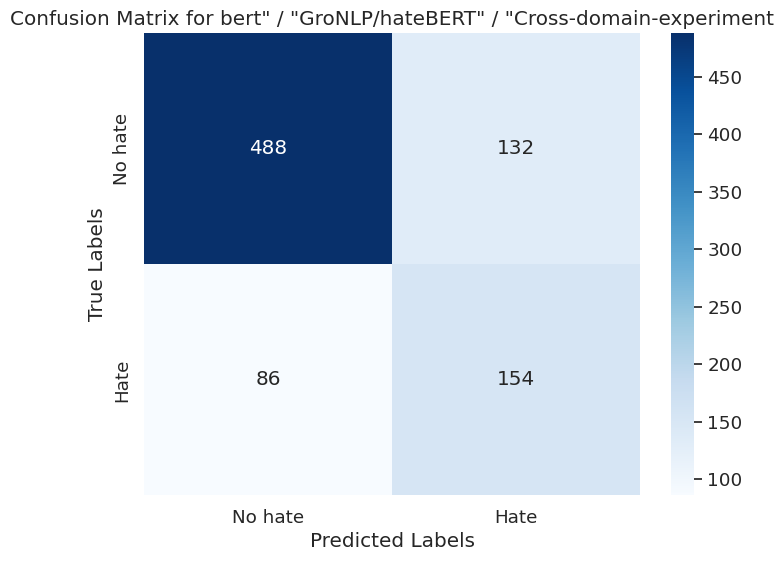

Classification Report for bert" / "GroNLP/hateBERT" / "Cross-domain-experiment:
              precision    recall  f1-score   support

           0       0.85      0.79      0.82       620
           1       0.54      0.64      0.59       240

    accuracy                           0.75       860
   macro avg       0.69      0.71      0.70       860
weighted avg       0.76      0.75      0.75       860



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/4681 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/586 [00:00<?, ?it/s]

  0%|          | 0/1171 [00:00<?, ?it/s]

  0%|          | 0/1171 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

<ipython-input-21-c82e727dfe4c>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_fold[f"prediction{model_type}"] = val_predictions


  0%|          | 0/4681 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/586 [00:00<?, ?it/s]

  0%|          | 0/1171 [00:00<?, ?it/s]

  0%|          | 0/1171 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

<ipython-input-21-c82e727dfe4c>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_fold[f"prediction{model_type}"] = val_predictions


  0%|          | 0/4682 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/586 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

<ipython-input-21-c82e727dfe4c>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_fold[f"prediction{model_type}"] = val_predictions


  0%|          | 0/4682 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/586 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

<ipython-input-21-c82e727dfe4c>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_fold[f"prediction{model_type}"] = val_predictions


  0%|          | 0/4682 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/586 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

<ipython-input-21-c82e727dfe4c>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_fold[f"prediction{model_type}"] = val_predictions


  0%|          | 0/860 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Confusion Matrix for roberta" / "roberta-base" / "Cross-domain-experiment:
[[524  96]
 [ 78 162]]


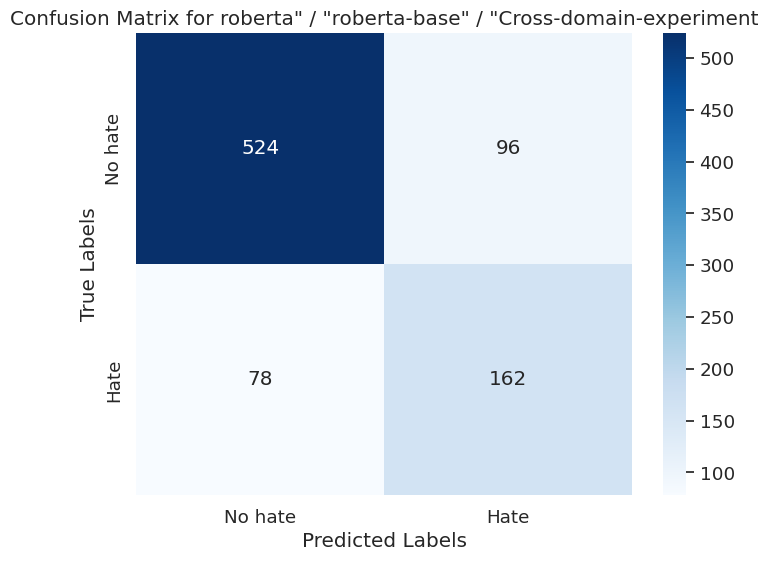

Classification Report for roberta" / "roberta-base" / "Cross-domain-experiment:
              precision    recall  f1-score   support

           0       0.87      0.85      0.86       620
           1       0.63      0.68      0.65       240

    accuracy                           0.80       860
   macro avg       0.75      0.76      0.75       860
weighted avg       0.80      0.80      0.80       860



In [52]:
# Stacking ensemble cross-domain
Stacking_cross_xlnet_predictions, Stacking_cross_xlnet_probabilities, cross_val_data_xlnet = fine_tune_and_evaluate(experiment_name='Cross-domain-experiment',
                        train_dataset= hasoc_train_df, val_dataset=val_hasoc,
                       test_dataset=OLIDv1_test_df,
                       model_type='xlnet', model_case='xlnet-base-cased', retrain=True, num_folds=5)

Stacking_cross_hateBert_predictions, Stacking_cross_hateBert_probabilities, cross_val_data_hateBert = fine_tune_and_evaluate(experiment_name='Cross-domain-experiment',
                        train_dataset= hasoc_train_df, val_dataset=val_hasoc,
                       test_dataset=OLIDv1_test_df,
                       model_type = 'bert', model_case='GroNLP/hateBERT',retrain=True, num_folds=5)

Stacking_cross_Roberta_predictions, Stacking_cross_Roberta_probabilities, cross_val_data_Roberta  = fine_tune_and_evaluate(experiment_name='Cross-domain-experiment',
                        train_dataset= hasoc_train_df, val_dataset=val_hasoc,
                       test_dataset=OLIDv1_test_df,
                       model_type='roberta', model_case='roberta-base', retrain=True, num_folds=5)

In [53]:
# Create a new DataFrame combining all prediction columns from different models
combined_val_df = pd.DataFrame({
    'text': in_val_data_xlnet['text'],
    'labels': in_val_data_xlnet['labels'],
    'cv_prediction xlnet': in_val_data_xlnet['predictionxlnet'],
    'cv_prediction cross_xlnet': cross_val_data_xlnet['predictionxlnet'],
    'cv_prediction hateBert': in_val_data_hateBert['predictionbert'],
    'cv_prediction cross_hateBert': cross_val_data_hateBert['predictionbert'],
    'cv_prediction roberta': in_val_data_Roberta['predictionroberta'],
    'cv_prediction cross_roberta': cross_val_data_Roberta['predictionroberta']
})

combined_val_df.head()


text  labels  \
0  @USER @USER @USER @USER @USER Hahah a left tel...       0   
1  @USER @USER I’m glad you do babe (I kiss you b...       0   
2          @USER And I have concerns with”Democrats”       0   
3                             @USER AS IT SHOULD BE!       0   
4  @USER @USER A horrendous act of course. Conser...       1   

   cv_prediction xlnet  cv_prediction cross_xlnet  cv_prediction hateBert  \
0                    0                          0                       0   
1                    0                          0                       0   
2                    0                          0                       0   
3                    0                          0                       0   
4                    1                          0                       1   

   cv_prediction cross_hateBert  cv_prediction roberta  \
0                             0                      0   
1                             1                      0   
2                             0                      0   
3                             0                      0   
4                             0                      1   

   cv_prediction cross_roberta  
0                            0  
1                            0  
2                            0  
3                            0  
4                            0

In [54]:
def count_vect(X_train, X_test):
    # Create CountVectorizer objects
    vec_word = CountVectorizer(analyzer='word', ngram_range=(1, 1), lowercase=False)
    vec_char = CountVectorizer(analyzer='char', ngram_range=(3, 3), lowercase=False)

    # Transform the text data
    X_train = hstack((vec_word.fit_transform(X_train), vec_char.fit_transform(X_train)))
    X_test = hstack((vec_word.transform(X_test), vec_char.transform(X_test)))

    # Convert X_test to list of comma-separated strings
    temp = [",".join(map(str, row.data)) for row in X_test]

    # Count the number of elements in each row of X_test
    row_counts = X_test.getnnz(axis=1)

    return row_counts

def feature_extraction(X_train, X_test, labels_column, lexicon, column_name=None):
    """
    Perform feature extractionhate frome speech.

    Parameters:
        X_train (pd.Series): Training text data for CountVectorizer.
        X_test (pd.Series): data to extracte feature to.
        labels_column (pd.Series): The column containing the true labels (0 for non-hate, 1 for hate).
        lexicon (pd.DataFrame): The lexicon containing hate speech terms and labels.
        column_name (str): The text column name in the lexicon DataFrame.

    Returns:
        pd.DataFrame: A DataFrame containing the original text, true labels,
                      normalized negative word count, normalized message length in terms of words,
                      normalized message length in terms of characters, relative number of uppercase characters,
                      relative number of exclamation marks, negative word count,
                      and features from CountVectorizer for both training and test data.
    """
    count_vector = count_vect(X_train,X_test)

    # Create a DataFrame to store results
    # results_df = pd.DataFrame()
    results_df = pd.DataFrame({'Text': X_test, 'True_Labels': labels_column})


    # Define a function to count negative words in the text
    def count_negative_words(text, lexicon):
        tokens = text.lower().split()  # Convert to lowercase for case-insensitive matching
        negative_word_count = 0
        for token in tokens:
            if token in lexicon[column_name].values:
                negative_word_count += 1
        return negative_word_count

    # Apply the count_negative_words function to the text data
    results_df['Negative_Word_Count'] = X_test.apply(lambda x: count_negative_words(x, lexicon))

    # Add message length in terms of words
    results_df['Words_Length'] = X_test.apply(lambda x: len(re.findall(r'\w+', x)))

    # Add message length in terms of characters
    results_df['Character_Length'] = X_test.apply(len)

    # Normalize Negative_Word_Count, Words_Length, and Character_Length
    results_df['Normalized Negative Word Count'] = results_df['Negative_Word_Count'] / results_df['Negative_Word_Count'].max()
    results_df['Normalized Words Length'] = results_df['Words_Length'] / results_df['Words_Length'].max()
    results_df['Normalized Character Length'] = results_df['Character_Length'] / results_df['Character_Length'].max()

    # Add the relative number of uppercase characters in each message
    results_df['Relative Uppercase Characters'] = X_test.apply(lambda x: sum(1 for c in x if c.isupper()) / len(x) if len(x) > 0 else 0)

    # Add the relative number of exclamation marks in each message
    results_df['Relative Exclamation Marks'] = X_test.apply(lambda x: x.count('!') / len(x) if len(x) > 0 else 0)

    results_df['count vector'] = count_vector
    results_df['Normalized count vector'] = count_vector/max(count_vector)

    return results_df

ensemble_test_df = feature_extraction(OLIDv1_train_df['text'], OLIDv1_test_df['text'], OLIDv1_test_df['labels'], lexicon_df, column_name='word')
ensemble_test_df = ensemble_test_df.drop(['Negative_Word_Count','Words_Length','Character_Length','count vector'],axis=1)
features_df = feature_extraction(OLIDv1_train_df['text'], combined_val_df['text'], combined_val_df['labels'], lexicon_df, column_name='word')
ensemble_train_df = pd.concat([features_df,combined_val_df.drop(["text","labels"],axis=1)], axis=1)
ensemble_train_df = ensemble_train_df.drop(['Negative_Word_Count','Words_Length','Character_Length','count vector'],axis=1)

In [55]:
ensemble_test_df['cv_prediction xlnet']=Stacking_xlnet_predictions
ensemble_test_df['cv_prediction cross_xlnet']=Stacking_cross_xlnet_predictions

ensemble_test_df['cv_prediction hateBert']=Stacking_hateBert_predictions
ensemble_test_df['cv_prediction cross_hateBert']=Stacking_cross_hateBert_predictions

ensemble_test_df['cv_prediction roberta']=Stacking_Roberta_predictions
ensemble_test_df['cv_prediction cross_roberta']=Stacking_cross_Roberta_predictions

display(ensemble_train_df.head())
display(ensemble_test_df.head())

Text  True_Labels  \
0  @USER @USER @USER @USER @USER Hahah a left tel...            0   
1  @USER @USER I’m glad you do babe (I kiss you b...            0   
2          @USER And I have concerns with”Democrats”            0   
3                             @USER AS IT SHOULD BE!            0   
4  @USER @USER A horrendous act of course. Conser...            1   

   Normalized Negative Word Count  Normalized Words Length  \
0                             0.0                 0.194175   
1                             0.0                 0.252427   
2                             0.0                 0.067961   
3                             0.0                 0.048544   
4                             0.4                 0.291262   

   Normalized Character Length  Relative Uppercase Characters  \
0                     0.194643                       0.192661   
1                     0.210714                       0.084746   
2                     0.073214                       0.170732   
3                     0.039286                       0.727273   
4                     0.294643                       0.066667   

   Relative Exclamation Marks  Normalized count vector  cv_prediction xlnet  \
0                    0.009174                 0.291139                    0   
1                    0.000000                 0.367089                    0   
2                    0.000000                 0.142405                    0   
3                    0.045455                 0.079114                    0   
4                    0.000000                 0.563291                    1   

   cv_prediction cross_xlnet  cv_prediction hateBert  \
0                          0                       0   
1                          0                       0   
2                          0                       0   
3                          0                       0   
4                          0                       1   

   cv_prediction cross_hateBert  cv_prediction roberta  \
0                             0                      0   
1                             1                      0   
2                             0                      0   
3                             0                      0   
4                             0                      1   

   cv_prediction cross_roberta  
0                            0  
1                            0  
2                            0  
3                            0  
4                            0

Text  True_Labels  \
0  #WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...            1   
1  #ConstitutionDay is revered by Conservatives, ...            0   
2  #FOXNews #NRA #MAGA #POTUS #TRUMP #2ndAmendmen...            0   
3  #Watching #Boomer getting the news that she is...            0   
4  #NoPasaran: Unity demo to oppose the far-right...            1   

   Normalized Negative Word Count  Normalized Words Length  \
0                        0.111111                 0.430769   
1                        0.222222                 0.230769   
2                        0.000000                 0.430769   
3                        0.000000                 0.369231   
4                        0.111111                 0.246154   

   Normalized Character Length  Relative Uppercase Characters  \
0                     0.780255                       0.240816   
1                     0.353503                       0.054054   
2                     0.649682                       0.357843   
3                     0.442675                       0.079137   
4                     0.312102                       0.102041   

   Relative Exclamation Marks  Normalized count vector  cv_prediction xlnet  \
0                    0.012245                 0.770548                    1   
1                    0.000000                 0.380137                    0   
2                    0.000000                 0.510274                    0   
3                    0.000000                 0.496575                    0   
4                    0.010204                 0.325342                    0   

   cv_prediction cross_xlnet  cv_prediction hateBert  \
0                          1                       0   
1                          0                       1   
2                          0                       1   
3                          0                       0   
4                          0                       0   

   cv_prediction cross_hateBert  cv_prediction roberta  \
0                             0                      1   
1                             1                      0   
2                             0                      0   
3                             0                      0   
4                             0                      0   

   cv_prediction cross_roberta  
0                            1  
1                            0  
2                            0  
3                            0  
4                            0

In [56]:
def svc_stacking_ensemble(X_train, y_train, X_test, y_test, experiment_name):
    # Standardize the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Build and train the SVC model
    svc_model = SVC(kernel='rbf', C=1.0, random_state=42)
    svc_model.fit(X_train_scaled, y_train)

    # Make predictions on the test data
    predictions = svc_model.predict(X_test_scaled)

    # Printing and plotting confusion matrix
    print_and_plot_confusion_matrix(y_test, predictions, experiment_name)

    # Printing classification report
    print_classification_report(y_test, predictions, experiment_name)

    return svc_model , predictions , X_test


Confusion Matrix for SVC stacking ensemble in-domain:
[[515 105]
 [ 65 175]]


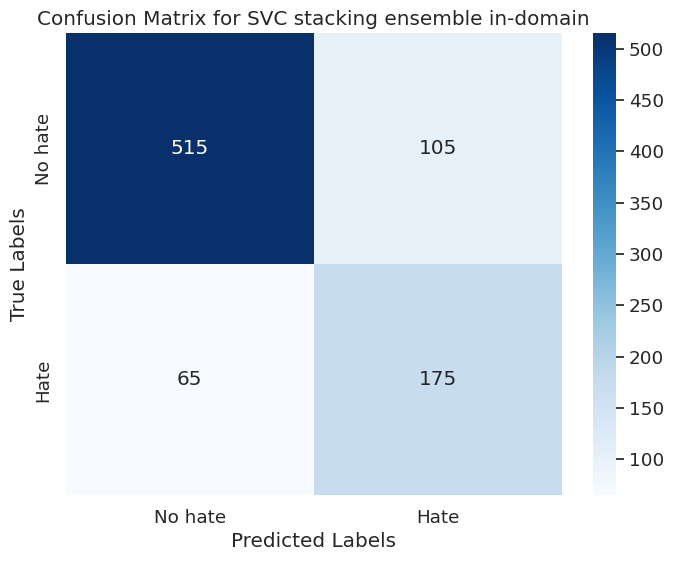

Classification Report for SVC stacking ensemble in-domain:
              precision    recall  f1-score   support

           0       0.89      0.83      0.86       620
           1       0.62      0.73      0.67       240

    accuracy                           0.80       860
   macro avg       0.76      0.78      0.77       860
weighted avg       0.81      0.80      0.81       860



In [57]:
# Extracting features (X) and labels (y)
X_train = ensemble_train_df.drop(columns=['True_Labels','Text','cv_prediction cross_xlnet','cv_prediction cross_hateBert','cv_prediction cross_roberta'])  # Features
y_train = ensemble_train_df['True_Labels']  # Labels

X_test = ensemble_test_df.drop(columns=['True_Labels','Text','cv_prediction cross_xlnet','cv_prediction cross_hateBert','cv_prediction cross_roberta'])  # Features
y_test = ensemble_test_df['True_Labels']  # Labels

# Call the function with your features (X) and labels (y) along with the experiment name
in_svc_model , ensemble_in_domain_predictions , test_data = svc_stacking_ensemble(X_train, y_train, X_test, y_test, "SVC stacking ensemble in-domain")

Confusion Matrix for SVC stacking ensemble cross-domain:
[[602  18]
 [203  37]]


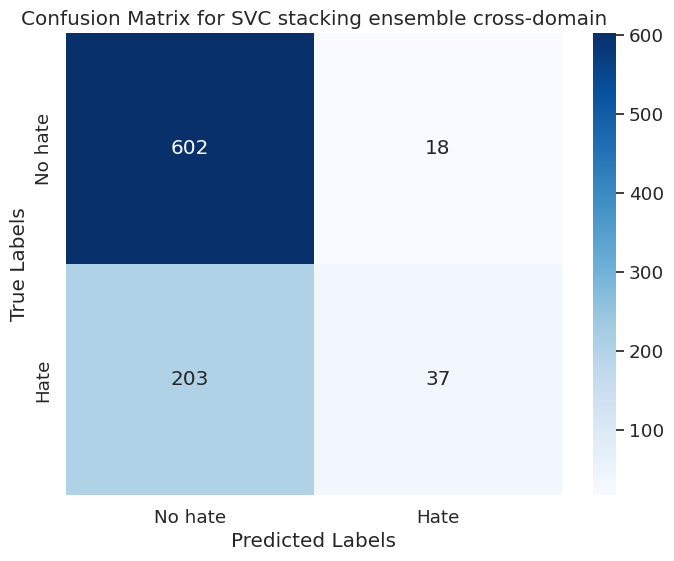

Classification Report for SVC stacking ensemble cross-domain:
              precision    recall  f1-score   support

           0       0.75      0.97      0.84       620
           1       0.67      0.15      0.25       240

    accuracy                           0.74       860
   macro avg       0.71      0.56      0.55       860
weighted avg       0.73      0.74      0.68       860



In [58]:
# Extracting features (X) and labels (y)
X_train = ensemble_train_df.drop(columns=['True_Labels','Text','cv_prediction xlnet','cv_prediction hateBert','cv_prediction roberta'])  # Features
y_train = ensemble_train_df['True_Labels']  # Labels

X_test = ensemble_test_df.drop(columns=['True_Labels','Text','cv_prediction xlnet','cv_prediction hateBert','cv_prediction roberta'])  # Features
y_test = ensemble_test_df['True_Labels']  # Labels

# Call the function with your features (X) and labels (y) along with the experiment name
cross_svc_model , ensemble_cross_domain_predictions , test_data_cross = svc_stacking_ensemble(X_train, y_train, X_test, y_test, "SVC stacking ensemble cross-domain")

==============================
# combine all predictions in one Dateframe
==============================

In [44]:
all_predictions= ensemble_test_df
all_predictions["in-domain stacking ensemble prediction"] = ensemble_in_domain_predictions
all_predictions["cross-domain stacking ensemble prediction"] = ensemble_cross_domain_predictions

all_predictions["hard majority predictions"] = hard_majority_predictions
all_predictions["cross hard majority predictions"] = cross_hard_majority_predictions

all_predictions["soft majority predictions"] = soft_majority_prediction
all_predictions["cross soft majority predictions"] = cross_soft_majority_prediction

all_predictions["roberta predictions"] = roberta_predictions
all_predictions["cross roberta predictions"] = cross_roberta_predictions

all_predictions["hateBERT predictions"] = hateBERT_predictions
all_predictions["cross hateBERT predictions"] = cross_hateBERT_predictions

all_predictions["xlnet predictions"] = xlnet_predictions
all_predictions["cross xlnet predictions"] = cross_xlnet_predictions
all_predictions.head()

Text  True_Labels  \
0  #WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...            1   
1  #ConstitutionDay is revered by Conservatives, ...            0   
2  #FOXNews #NRA #MAGA #POTUS #TRUMP #2ndAmendmen...            0   
3  #Watching #Boomer getting the news that she is...            0   
4  #NoPasaran: Unity demo to oppose the far-right...            1   

   Normalized Negative Word Count  Normalized Words Length  \
0                        0.111111                 0.430769   
1                        0.222222                 0.230769   
2                        0.000000                 0.430769   
3                        0.000000                 0.369231   
4                        0.111111                 0.246154   

   Normalized Character Length  Relative Uppercase Characters  \
0                     0.780255                       0.240816   
1                     0.353503                       0.054054   
2                     0.649682                       0.357843   
3                     0.442675                       0.079137   
4                     0.312102                       0.102041   

   Relative Exclamation Marks  Normalized count vector  cv_prediction xlnet  \
0                    0.012245                 0.770548                    1   
1                    0.000000                 0.380137                    0   
2                    0.000000                 0.510274                    0   
3                    0.000000                 0.496575                    0   
4                    0.010204                 0.325342                    0   

   cv_prediction cross_xlnet  ...  hard majority predictions  \
0                          1  ...                          0   
1                          0  ...                          0   
2                          0  ...                          0   
3                          0  ...                          0   
4                          0  ...                          0   

   cross hard majority predictions  soft majority predictions  \
0                                0                          0   
1                                0                          0   
2                                0                          0   
3                                0                          0   
4                                0                          0   

   cross soft majority predictions  roberta predictions  \
0                                0                    1   
1                                0                    0   
2                                0                    0   
3                                0                    0   
4                                0                    0   

   cross roberta predictions  hateBERT predictions  \
0                          1                     0   
1                          0                     0   
2                          0                     0   
3                          0                     0   
4                          0                     0   

   cross hateBERT predictions  xlnet predictions  cross xlnet predictions  
0                           0                  0                        0  
1                           0                  0                        0  
2                           0                  0                        0  
3                           0                  0                        0  
4                           0                  0                        0  

[5 rows x 26 columns]

In [48]:
all_predictions

Text  True_Labels  \
0    #WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...            1   
1    #ConstitutionDay is revered by Conservatives, ...            0   
2    #FOXNews #NRA #MAGA #POTUS #TRUMP #2ndAmendmen...            0   
3    #Watching #Boomer getting the news that she is...            0   
4    #NoPasaran: Unity demo to oppose the far-right...            1   
..                                                 ...          ...   
855  #DespicableDems lie again about rifles. Dem Di...            1   
856  #MeetTheSpeakers 🙌 @USER will present in our e...            0   
857  3 people just unfollowed me for talking about ...            1   
858  #WednesdayWisdom Antifa calls the right fascis...            0   
859      #Kavanaugh typical #liberals , #Democrats URL            0   

     Normalized Negative Word Count  Normalized Words Length  \
0                          0.111111                 0.430769   
1                          0.222222                 0.230769   
2                          0.000000                 0.430769   
3                          0.000000                 0.369231   
4                          0.111111                 0.246154   
..                              ...                      ...   
855                        0.111111                 0.292308   
856                        0.000000                 0.584615   
857                        0.111111                 0.600000   
858                        0.222222                 0.646154   
859                        0.000000                 0.076923   

     Normalized Character Length  Relative Uppercase Characters  \
0                       0.780255                       0.240816   
1                       0.353503                       0.054054   
2                       0.649682                       0.357843   
3                       0.442675                       0.079137   
4                       0.312102                       0.102041   
..                           ...                            ...   
855                     0.385350                       0.140496   
856                     0.789809                       0.116935   
857                     0.652866                       0.000000   
858                     0.850318                       0.026217   
859                     0.143312                       0.111111   

     Relative Exclamation Marks  Normalized count vector  cv_prediction xlnet  \
0                      0.012245                 0.770548                    1   
1                      0.000000                 0.380137                    0   
2                      0.000000                 0.510274                    0   
3                      0.000000                 0.496575                    0   
4                      0.010204                 0.325342                    0   
..                          ...                      ...                  ...   
855                    0.000000                 0.452055                    1   
856                    0.000000                 0.780822                    0   
857                    0.000000                 0.688356                    1   
858                    0.000000                 0.910959                    0   
859                    0.000000                 0.164384                    0   

     cv_prediction cross_xlnet  ...  hard majority predictions  \
0                            1  ...                          0   
1                            0  ...                          0   
2                            0  ...                          0   
3                            0  ...                          0   
4                            0  ...                          0   
..                         ...  ...                        ...   
855                          0  ...                          0   
856                          0  ...                          0   
857                          1  ...                     

In [59]:
def get_false_samples(text, true_labels, predictions, case=None):
    false_samples = []
    for i in range(len(true_labels)):
        # Strip whitespace from text (if applicable) and then compare
        text_i = text[i].strip() if isinstance(text[i], str) else text[i]
        if case == "false_positive":
            if true_labels[i] == 0 and predictions[i] == 1:
                false_samples.append(i)
        elif case == "false_negative":
            if true_labels[i] == 1 and predictions[i] == 0:
                false_samples.append(i)

    false_df = pd.DataFrame({'Text': [text[i] for i in false_samples],
                             'True_Labels': [true_labels[i] for i in false_samples],
                             'Predictions': [predictions[i] for i in false_samples]})
    return false_df


x = get_false_samples(all_predictions['Text'],all_predictions["True_Labels"], all_predictions["hard majority predictions"], case="false_negative")
x.head(15)

Text  True_Labels  \
0   #WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...            1   
1   #NoPasaran: Unity demo to oppose the far-right...            1   
2                         @USER Nigga ware da hits at            1   
3   #ChristineBlaseyFord is your #Kavanaugh accuse...            1   
4   #Kids Beating #Paraplegic #Trump #Boy!  #Left ...            1   
5   #ANTIFA are bedfellows with The Democratic Soc...            1   
6    @USER Antifa has TS level influence. It's scary.            1   
7   #SerenaWilliams is so full of herself...she is...            1   
8   #MAGA #Qanon #GreatAwakening #inners #WWG1WGA ...            1   
9   @USER #WalkAwayFromAllDemocrats  Michelle was ...            1   
10  #BlaseyFord It’s so comical that liberals alwa...            1   
11  #Ted always has a feel for the most appropriat...            1   
12               @USER #Holder needed to be impeached            1   
13  #BelieveAllWomen just when I think things can'...            1   
14  #SierraBurgessIsALoser  She is me when my phon...            1   

    Predictions  
0             0  
1             0  
2             0  
3             0  
4             0  
5             0  
6             0  
7             0  
8             0  
9             0  
10            0  
11            0  
12            0  
13            0  
14            0

# Discussion performance loss cross-domain

In [ ]:
# The code after this was used for getting insight into the difference in model performance when transitioning from in-domain to cross-domain settings.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

# Load datasets
OLIDv1_train_df = pd.read_csv(olid_url)
OLIDv1_test_df = pd.read_csv(olid_test_url)
HASOC_train_df = pd.read_csv(hasoc_url)

# 1. Length of Messages
OLIDv1_train_df['length'] = OLIDv1_train_df['text'].apply(len)
OLIDv1_test_df['length'] = OLIDv1_test_df['text'].apply(len)
HASOC_train_df['length'] = HASOC_train_df['text'].apply(len)

print("Average length in OLID training data:", OLIDv1_train_df['length'].mean())
print("Average length in OLID test data:", OLIDv1_test_df['length'].mean())
print("Average length in HASOC training data:", HASOC_train_df['length'].mean())

In [ ]:
import nltk
nltk.download('stopwords')

In [ ]:
# 2. Topical Focus
from gensim import corpora
from gensim.models import LdaModel
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import nltk
import gensim
nltk.download('punkt')

# Preprocess data
def preprocess(text):
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words and word not in string.punctuation]
    return tokens

OLIDv1_train_df['tokens'] = OLIDv1_train_df['text'].apply(preprocess)
OLIDv1_test_df['tokens'] = OLIDv1_test_df['text'].apply(preprocess)
HASOC_train_df['tokens'] = HASOC_train_df['text'].apply(preprocess)

# Create dictionary and corpus for LDA
def generate_lda_topics(data, num_topics=5):
    dictionary = corpora.Dictionary(data)
    corpus = [dictionary.doc2bow(text) for text in data]
    lda = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15)
    return lda.print_topics(-1)

print("Topics in OLID training data:")
topics_olid_train = generate_lda_topics(OLIDv1_train_df['tokens'])
for topic in topics_olid_train:
    print(topic)

print("\nTopics in OLID test data:")
topics_olid_test = generate_lda_topics(OLIDv1_test_df['tokens'])
for topic in topics_olid_test:
    print(topic)

print("\nTopics in HASOC training data:")
topics_hasoc_train = generate_lda_topics(HASOC_train_df['tokens'])
for topic in topics_hasoc_train:
    print(topic)

In [ ]:
import pandas as pd

# Load datasets
# OLIDv1_train_df = pd.read_csv("olid-train.csv")
# OLIDv1_test_df = pd.read_csv("olid-test.csv")
# HASOC_train_df = pd.read_csv("hasoc-train.csv")

# Extract unique words from each dataset
OLID_train_words = set(" ".join(OLIDv1_train_df['text']).split())
OLID_test_words = set(" ".join(OLIDv1_test_df['text']).split())
HASOC_train_words = set(" ".join(HASOC_train_df['text']).split())

# Words in OLID test set but not in OLID train set
missing_words_in_domain = OLID_test_words - OLID_train_words

# Words in OLID test set but not in HASOC train set
missing_words_cross_domain = OLID_test_words - HASOC_train_words

print(f"Number of words in OLID test set not seen in OLID train set: {len(missing_words_in_domain)}")
print(f"Number of words in OLID test set not seen in HASOC train set: {len(missing_words_cross_domain)}")